### 1.
Importing data and splitting into test, validation and training data. (Only run one time)

In [1]:
import os
import numpy as np
import pandas as pd
import torch

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

def split_dataframe_rows(df, train_frac, val_frac, test_frac, seed=42):
    """Split the *rows* of the original df into train/val/test by fraction."""
    assert abs((train_frac + val_frac + test_frac) - 1.0) < 1e-8, "Fractions must sum to 1."
    rng = np.random.default_rng(seed)
    idx = df.index.to_numpy()
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(round(train_frac * n))
    n_val = int(round(val_frac * n))
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    return df.loc[train_idx], df.loc[val_idx], df.loc[test_idx]


def expand_split(df_split):
    """
    Expand a split of the original df into (X, Y) arrays by iterating each row,
    parsing vector fields, masking NaNs per-row, and stacking all samples.
    """
    inputs, outputs = [], []

    for _, row in df_split.iterrows():
        # ---- scalar inputs (with the same preprocessing as in your pipeline) ----
        dV_ges   = float(row["dV_ges"]) / 3.6 * 1e-6
        eps_0    = float(row["eps_0"])
        phi_0    = float(row["phi_0"])
        h_dis_0  = float(row["h_dis_0"])
        h_c_0    = float(row["h_c_0"])
        rho_c    = float(row["rho_c"])
        rho_d    = float(row["rho_d"])
        eta_c    = float(row["eta_c"])
        eta_d    = float(row["etc_d"])
        sigma    = float(row["sigma"])
        T        = float(row["T"])
        r_s_star = float(row["r_S_star"])
        h_p_star = float(row["h_p_star"])
        lam      = float(row["lambda"])

        # ---- vector fields (convert units like before) ----
        DPZ_pos    = np.fromstring(str(row['DPZ_pos_ivgu']).strip("[]"), sep=",") / 100.0     # m
        DPZ_height = np.fromstring(str(row['DPZ_height_ivgu']).strip("[]"), sep=",") / 1000.0 # m
        DPZ_bot    = np.fromstring(str(row['DPZ_bot_ivgu']).strip("[]"), sep=",") / 1000.0   # m

        # ---- per-row NaN mask to keep only valid aligned entries ----
        mask = ~(np.isnan(DPZ_pos) | np.isnan(DPZ_height) | np.isnan(DPZ_bot))
        if not np.any(mask):
            continue  # skip row if nothing valid

        DPZ_pos_v    = DPZ_pos[mask]
        DPZ_height_v = DPZ_height[mask]
        DPZ_bot_v    = DPZ_bot[mask]

        # ---- expand: one sample per DPZ position ----
        const_feats = [dV_ges, eps_0, phi_0, h_dis_0, h_c_0, rho_c, rho_d,
                       eta_c, eta_d, sigma, T, r_s_star, h_p_star]
        for i in range(len(DPZ_pos_v)):
            x_vec = const_feats + [DPZ_pos_v[i]]
            y_vec = [lam, DPZ_height_v[i], DPZ_bot_v[i]]
            inputs.append(x_vec)
            outputs.append(y_vec)

    X = np.array(inputs, dtype=DTYPE)
    Y = np.array(outputs, dtype=DTYPE)
    return X, Y

In [2]:
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15
SEED = 42
DTYPE = np.float32
CSV_PATH = os.path.join("Input", "sz.csv")

# 1) Read original CSV
df = pd.read_csv(CSV_PATH)

# 2) Split by original rows (no expansion yet)
train_df, val_df, test_df = split_dataframe_rows(df, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED)
print(f"Row splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# 3) Expand each split separately (no cross-split leakage)
X_train, Y_train = expand_split(train_df)
X_val,   Y_val   = expand_split(val_df)
X_test,  Y_test  = expand_split(test_df)

print("Expanded sample counts:", f"train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print("Feature/Target dims:", X_train.shape[1], Y_train.shape[1])

# 4) Fit Min–Max on TRAIN only; transform all splits
x_mins, x_rng = fit_minmax(X_train)
y_mins, y_rng = fit_minmax(Y_train)

X_train_n = transform_minmax(X_train, x_mins, x_rng)
X_val_n   = transform_minmax(X_val,   x_mins, x_rng)
X_test_n  = transform_minmax(X_test,  x_mins, x_rng)

Y_train_n = transform_minmax(Y_train, y_mins, y_rng)
Y_val_n   = transform_minmax(Y_val,   y_mins, y_rng)
Y_test_n  = transform_minmax(Y_test,  y_mins, y_rng)

# 5) Convert to torch tensors (ready for DataLoaders)
X_train_t = torch.from_numpy(X_train_n)
Y_train_t = torch.from_numpy(Y_train_n)
X_val_t   = torch.from_numpy(X_val_n)
Y_val_t   = torch.from_numpy(Y_val_n)
X_test_t  = torch.from_numpy(X_test_n)
Y_test_t  = torch.from_numpy(Y_test_n)

print("Torch tensors:",
      X_train_t.shape, Y_train_t.shape,
      X_val_t.shape,   Y_val_t.shape,
      X_test_t.shape,  Y_test_t.shape)

# Save normalization params for inference-time inverse-transform
np.savez(
    "minmax_params_dnn_3_(sz).npz",
    x_mins=x_mins, x_rng=x_rng,
    y_mins=y_mins, y_rng=y_rng
)

# Save splits as torch tensors
data = {
    "X_train_t": X_train_t,
    "Y_train_t": Y_train_t,
    "X_val_t":   X_val_t,
    "Y_val_t":   Y_val_t,
    "X_test_t":  X_test_t,
    "Y_test_t":  Y_test_t,
    "X_train_n": X_train_n,
    "Y_train_n": Y_train_n,
    "X_val_n":   X_val_n,
    "Y_val_n":   Y_val_n,
    "X_test_n":  X_test_n,
    "Y_test_n":  Y_test_n,
}

# Save all in one file
torch.save(data, 'datasets_dnn_3_(sz).pt')

Row splits: train=253, val=54, test=55
Expanded sample counts: train=6595, val=1415, test=1394
Feature/Target dims: 14 3
Torch tensors: torch.Size([6595, 14]) torch.Size([6595, 3]) torch.Size([1415, 14]) torch.Size([1415, 3]) torch.Size([1394, 14]) torch.Size([1394, 3])


### 2.
Creating the model

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import math
import matplotlib.pyplot as plt


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True  # faster on GPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_data = torch.load("saved_models/dnn_3_(sz)/datasets_dnn_3_(sz).pt")

# Access tensors or arrays
X_train_t = loaded_data["X_train_t"]
X_train_n = loaded_data["X_train_n"]
Y_train_t = loaded_data["Y_train_t"]
Y_train_n = loaded_data["Y_train_n"]
X_val_t = loaded_data["X_val_t"]
X_val_n = loaded_data["X_val_n"]
Y_val_t = loaded_data["Y_val_t"]
Y_val_n = loaded_data["Y_val_n"]
X_test_t = loaded_data["X_test_t"]
X_test_n = loaded_data["X_test_n"]
Y_test_t = loaded_data["Y_test_t"]
Y_test_n = loaded_data["Y_test_n"]

loaded_data_n = np.load("saved_models/dnn_3_(sz)/minmax_params_dnn_3_(sz).npz")
x_mins = loaded_data_n["x_mins"]
x_rng = loaded_data_n["x_rng"]
y_mins = loaded_data_n["y_mins"]
y_rng = loaded_data_n["y_rng"]


class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation="silu", dropout=0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh
        }
        if activation not in acts:
            raise ValueError(f"activation must be one of {list(acts.keys())}")
        Act = acts[activation]

        layers = []
        prev = in_dim
        for i, h in enumerate(hidden_dims):
            layers += [nn.Linear(prev, h), Act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(p=dropout)]
            prev = h
        # Linear output for regression
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

        # Weight init (He for ReLU/SiLU/GELU, Xavier for Tanh)
        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu", "gelu"):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                else:  # tanh
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        return self.net(x)
    
in_dim  = X_train_t.shape[1]
out_dim = Y_train_t.shape[1]
hidden  = [128, 512]
dropout = 0.04188001122571999
activation = 'relu'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN(in_dim, hidden, out_dim, activation=activation, dropout=dropout).to(device)

C:\Users\Asus\AppData\Local\Temp\ipykernel_16204\2007295990.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load("saved_models/dnn_3_(sz)/datasets_d

### 4.
Train the model

In [2]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
test_ds  = TensorDataset(X_test_t,  Y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds,   batch_size=2048, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()  # targets are scaled; MSE is fine
lr = 0.000976533339165421
weight_decay = 2.3494060699525925e-07
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=30)


Training loop

In [3]:
EPOCHS = 200
PATIENCE = 30
steps_per_epoch = max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)
best_val = float("inf")
best_state = None
epochs_no_improve = 0
losses_history = []

for epoch in range(1, EPOCHS + 1):
    # train
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    lr = optimizer.param_groups[0]['lr']
    losses_history.append([train_loss, val_loss, lr])

    scheduler.step(val_loss)

    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch:03d} | train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f} | LR: {lr:.2e}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best val MSE: {best_val:.6f}")
        break


# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

NameError: name 'train_loader' is not defined

In [9]:
print(f"Best val MSE: {best_val:.6f}")

Best val MSE: 0.002968


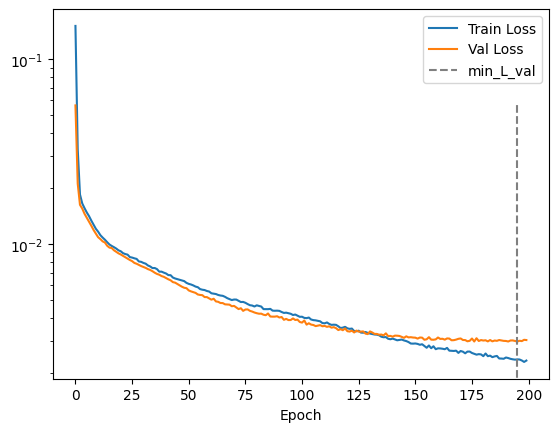

In [4]:
import matplotlib.pyplot as plt
losses_history = np.array(losses_history)
plt.plot(losses_history[:,0], label='Train Loss')
plt.plot(losses_history[:,1], label='Val Loss')
plt.vlines(np.argmin(losses_history[:,1]), linestyles='--', ymin=0, ymax=max(losses_history[:,1]), label='min_L_val', color='gray')
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Test the trained model

In [18]:
def evaluate_mse(loader):
    model.eval()
    mse = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            mse += loss.item() * xb.size(0)
    return mse / len(loader.dataset)

test_mse = evaluate_mse(test_loader)
print(f"Test MSE: {test_mse:.6f}")

Test MSE: 0.004745


See metrics in original units

In [16]:
DTYPE = np.float32

def fit_minmax(X):
    """Fit per-feature min-max on X (2D). Returns (mins, ranges) with safe ranges."""
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = maxs - mins
    rng_safe = np.where(rng > 0, rng, 1.0)  # avoid division by zero (constant features)
    return mins.astype(DTYPE), rng_safe.astype(DTYPE)

def transform_minmax(X, mins, rng_safe):
    return ((X - mins) / rng_safe).astype(DTYPE)

def inverse_minmax(X_scaled, mins, rng_safe):
    return (X_scaled * rng_safe + mins).astype(DTYPE)

try:
    mm = np.load("saved_models/dnn_3_(sz)/minmax_params_dnn_3_(sz).npz")
    y_mins, y_rng = mm["y_mins"], mm["y_rng"]

    # Compute MAE/RMSE in original units
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    preds_u = inverse_minmax(preds, y_mins, y_rng)
    trues_u = inverse_minmax(trues, y_mins, y_rng)

    mae = np.mean(np.abs(preds_u - trues_u), axis=0)
    mape = 100 * np.mean(np.abs((preds_u - trues_u) / trues_u), axis=0)
    rmse = np.sqrt(np.mean((preds_u - trues_u) ** 2, axis=0))
    mse = np.mean((preds_u - trues_u) ** 2, axis=0)
    print("Test MAE (original units) per target:", mae)
    print("Test MAPE (original units) per target:", mape, '%')
    print("Test RMSE (original units) per target:", rmse)
    print("Test MSE (original units) per target:", mse)
except FileNotFoundError:
    print("minmax_params.npz not found; skipping metrics in original units.")

Test MAE (original units) per target: [0.00090368 0.00333973 0.00171526]
Test MAPE (original units) per target: [ 0.09118525 12.081275    1.6561624 ] %
Test RMSE (original units) per target: [0.00137256 0.00511481 0.00270822]
Test MSE (original units) per target: [1.8839331e-06 2.6161297e-05 7.3344486e-06]


Save the model

In [7]:
torch.save(model.state_dict(), "dnn_3.pt")
print("Saved model to dnn_2.pt")

Saved model to dnn_2.pt


### 5.
See results

C:\Users\iagr9\AppData\Local\Temp\ipykernel_104552\3800467297.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dnn_1.pt"))


Predictions (10 rows, unnormalized/original units):
[[0.99287397 0.03805349 0.10114258]
 [0.99290425 0.03797169 0.10083118]
 [0.9929335  0.03741462 0.10047552]
 [0.9929566  0.03622846 0.10010925]
 [0.99296784 0.03427822 0.09977768]
 [0.99296284 0.03149965 0.09953292]
 [0.99293995 0.02796858 0.09942468]
 [0.99290204 0.02396763 0.09948894]
 [0.9928567  0.02001463 0.09973994]
 [0.99281484 0.01681774 0.10017047]]


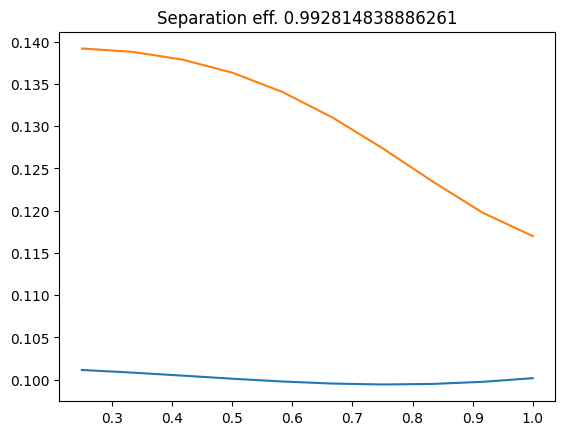

In [26]:
import matplotlib.pyplot as plt
# Load saved model if needed
hidden  = [128, 128, 128]  # good starting point; try [128,128] if you want simpler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = 14
out_dim = 3
model = DNN(in_dim, hidden, out_dim, activation="silu", dropout=0.0).to(device)
model.load_state_dict(torch.load("dnn_1.pt"))
model.eval()  # set to evaluation mode


dV_ges    = 1007         # original units (as in CSV)
eps_0     = 0.4
phi_0     = 551e-6
h_dis_0   = 0.04
h_c_0     = 0.1
rho_c     = 1000
rho_d     = 825
eta_c     = 82e-5
eta_d     = 604e-5
sigma     = 0.00817
T         = 30
r_s_star  = 0.0085
h_p_star  = 0.2211
x_array   = np.linspace(0.25, 1.0, 10)  # DPZ_pos

# Apply the SAME transformations you used when building X in training:
# dV_ges -> /3.6 * 1e-6 ; DPZ_pos was in meters AFTER dividing by 100 in the CSV pipeline.
# Here, x_array is already in meters, so no extra /100.
dV_ges_tr = dV_ges / 3.6 * 1e-6

const_feats = np.array(
    [dV_ges_tr, eps_0, phi_0, h_dis_0, h_c_0,
     rho_c, rho_d, eta_c, eta_d, sigma, T, r_s_star, h_p_star],
    dtype=np.float32
)

# Stack 10 rows, each with the 13 constant features + the varying DPZ_pos
X_real = np.hstack([
    np.repeat(const_feats[None, :], repeats=len(x_array), axis=0),
    x_array.reshape(-1, 1).astype(np.float32)
])  # shape (10, 14)

assert X_real.shape[1] == in_dim, f"Expected {in_dim} features, got {X_real.shape[1]}."

X_scaled = transform_minmax(X_real, x_mins, x_rng)
X_t = torch.from_numpy(X_scaled).to(device)

with torch.no_grad():
    Y_scaled = model(X_t).cpu().numpy()

def transform_minmax(X, mins, rng):
    rng_safe = np.where(rng > 0, rng, 1.0)
    return (X - mins) / rng_safe

def inverse_minmax(Ys, mins, rng):
    return Ys * rng + mins

Y_pred = inverse_minmax(Y_scaled, y_mins, y_rng)  

print("Predictions (10 rows, unnormalized/original units):")
print(Y_pred)

plt.plot(x_array, Y_pred[:, 2])
plt.plot(x_array, Y_pred[:,1]+Y_pred[:,2], label='DPZ_top')
plt.title(f'Separation eff. {Y_pred[-1,0]}')
plt.show()

In [4]:
with np.load("utils/dataset_splits_minmax.npz") as d:
    X_train = d["X_train"]
    X_val = d["X_val"]
    X_test = d["X_test"]
    Y_train = d["Y_train"]
    Y_val = d["Y_val"]
    Y_test = d["Y_test"]

### 6.
Make optuna study for determining optimal hyper-parameters

In [1]:
# tune_dnn_optuna.py
import os
import json
import math
from datetime import datetime

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

# --------------------
# Config
# --------------------
DATA_BUNDLE_DIR = "saved_models/dnn_3_(sz)"
DATA_TORCH_PATH = os.path.join(DATA_BUNDLE_DIR, "datasets_dnn_3_(sz).pt")
MM_PARAMS_NPZ   = os.path.join(DATA_BUNDLE_DIR, "minmax_params_dnn_3_(sz).npz")
RESULTS_DIR     = os.path.join(DATA_BUNDLE_DIR, "optuna_runs")

os.makedirs(RESULTS_DIR, exist_ok=True)

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True  # faster on GPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose which split variant to use: "t" or "n"
SPLIT_VARIANT = "t"  # change to "n" if you want *_n

# --------------------
# Load data
# --------------------
if not os.path.exists(DATA_TORCH_PATH):
    raise FileNotFoundError(f"Could not find {DATA_TORCH_PATH}")

loaded_data = torch.load(DATA_TORCH_PATH)

X_train = loaded_data[f"X_train_{SPLIT_VARIANT}"].float()
Y_train = loaded_data[f"Y_train_{SPLIT_VARIANT}"].float()
X_val   = loaded_data[f"X_val_{SPLIT_VARIANT}"].float()
Y_val   = loaded_data[f"Y_val_{SPLIT_VARIANT}"].float()
X_test  = loaded_data[f"X_test_{SPLIT_VARIANT}"].float()
Y_test  = loaded_data[f"Y_test_{SPLIT_VARIANT}"].float()

mm = np.load(MM_PARAMS_NPZ)
y_mins = torch.tensor(mm["y_mins"], dtype=torch.float32)
y_rng  = torch.tensor(mm["y_rng"],  dtype=torch.float32)

in_dim  = X_train.shape[1]
out_dim = Y_train.shape[1]

# --------------------
# Model definition (copied from your DNN with same init)
# --------------------
class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation="silu", dropout=0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "silu": nn.SiLU,
            "tanh": nn.Tanh
        }
        if activation not in acts:
            raise ValueError(f"activation must be one of {list(acts.keys())}")
        Act = acts[activation]

        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), Act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(p=dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                if activation in ("relu", "silu", "gelu"):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                else:
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        return self.net(x)

# --------------------
# Helpers
# --------------------
def denorm_y(y_norm: torch.Tensor) -> torch.Tensor:
    # y = y_norm * y_rng + y_mins (broadcast over batch)
    return y_norm * y_rng.to(y_norm.device) + y_mins.to(y_norm.device)

@torch.no_grad()
def mse_original_scale(model: nn.Module, loader: DataLoader, device=DEVICE) -> float:
    model.eval()
    se_sum, n_obs = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        pred_den = denorm_y(pred)
        y_den    = denorm_y(yb)
        se_sum += torch.sum((pred_den - y_den) ** 2).item()
        n_obs  += yb.numel()
    mse = se_sum / n_obs
    return float(mse)

def make_hidden_dims(trial: optuna.Trial) -> list:
    n_layers = trial.suggest_int("n_layers", 1, 4)
    dims = []
    for i in range(n_layers):
        dims.append(trial.suggest_categorical(f"width_l{i+1}", [64, 96, 128, 192, 256, 384, 512]))
    return dims

def make_optimizer(opt_name: str, params, lr: float, wd: float):
    if opt_name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif opt_name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    else:
        raise ValueError(opt_name)

# --------------------
# Objective
# --------------------
def objective(trial: optuna.Trial) -> float:
    # Search space
    hidden_dims = make_hidden_dims(trial)
    activation  = trial.suggest_categorical("activation", ["relu", "gelu", "silu", "tanh"])
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)
    lr          = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    weight_decay= trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    optimizer_n = trial.suggest_categorical("optimizer", ["adam", "adamw"])
    max_epochs  = trial.suggest_int("max_epochs", 80, 250)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=2048, shuffle=False, drop_last=False)

    # Model / opt / loss
    model = DNN(in_dim, hidden_dims, out_dim, activation=activation, dropout=dropout).to(DEVICE)
    opt   = make_optimizer(optimizer_n, model.parameters(), lr, weight_decay)
    loss_fn = nn.MSELoss()

    # OneCycleLR (optional): only if epochs >= 50
    use_scheduler = max_epochs >= 50
    if use_scheduler:
        steps_per_epoch = max(1, len(train_loader))
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=max_epochs, steps_per_epoch=steps_per_epoch)
    else:
        scheduler = None

    # Early stopping + pruning
    best_val = float("inf")
    best_state = None
    patience = 30
    patience_left = patience

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            if scheduler:
                scheduler.step()

        # Validation metric (original scale MSE)
        val_mse = mse_original_scale(model, val_loader, device=DEVICE)

        # Report to Optuna and check pruning
        trial.report(val_mse, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping tracking
        if val_mse < best_val - 1e-6:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    # Optionally save the trial's best model
    trial_dir = os.path.join(RESULTS_DIR, f"trial_{trial.number:04d}")
    os.makedirs(trial_dir, exist_ok=True)
    with open(os.path.join(trial_dir, "params.json"), "w") as f:
        json.dump(trial.params, f, indent=2)
    if best_state is not None:
        torch.save(best_state, os.path.join(trial_dir, "best_state.pt"))

    return best_val

# --------------------
# Run Study
# --------------------
def main():
    study_name = f"dnn_optuna_{SPLIT_VARIANT}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    storage = None  # e.g., "sqlite:///optuna_dnn.db" if you want persistence
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",
        storage=storage,
        load_if_exists=False,
        pruner=MedianPruner(n_warmup_steps=15),
        sampler=optuna.samplers.TPESampler(seed=SEED, n_startup_trials=15, multivariate=True, group=True),
    )

    # You can adjust n_trials as you like
    study.optimize(objective, n_trials=60, show_progress_bar=True, gc_after_trial=True)

    print("\nStudy statistics:")
    print(f"  Completed trials: {len(study.trials)}")
    pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    print(f"  Pruned trials: {len(pruned_trials)}")
    print(f"  Successful trials: {len(complete_trials)}")

    print("\nBest trial:")
    best = study.best_trial
    print(f"  Value (Val MSE, original scale): {best.value:.6f}")
    print("  Params:")
    for k, v in best.params.items():
        print(f"    {k}: {v}")

    # Save best params + optionally evaluate on test set using saved state
    best_dir = os.path.join(RESULTS_DIR, "best")
    os.makedirs(best_dir, exist_ok=True)
    with open(os.path.join(best_dir, "best_params.json"), "w") as f:
        json.dump(best.params, f, indent=2)

    # Rebuild best model and evaluate on test
    hidden_dims = [best.params[f"width_l{i+1}"] for i in range(best.params["n_layers"])]
    model = DNN(in_dim, hidden_dims, out_dim,
                activation=best.params["activation"],
                dropout=best.params["dropout"]).to(DEVICE)

    # Load the saved state from the best trial directory if present; otherwise use current weights
    best_trial_dir = os.path.join(RESULTS_DIR, f"trial_{best.number:04d}")
    state_path = os.path.join(best_trial_dir, "best_state.pt")
    if os.path.exists(state_path):
        model.load_state_dict(torch.load(state_path, map_location=DEVICE))

    test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=4096, shuffle=False)
    test_mse = mse_original_scale(model, test_loader, device=DEVICE)
    print(f"\nTest MSE (original scale): {test_mse:.6f}")
    with open(os.path.join(best_dir, "best_summary.json"), "w") as f:
        json.dump({"val_mse": best.value, "test_mse": test_mse, "trial_number": best.number}, f, indent=2)

    # Save final best model weights
    torch.save(model.state_dict(), os.path.join(best_dir, "best_model_state.pt"))

if __name__ == "__main__":
    main()


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\2106444734.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

[I 2025-08-24 11:08:09,777] Trial 0 finished with value: 1.2061154322854482e-05 and parameters: {'n_layers': 1, 'width_l1': 512, 'activation': 'relu', 'dropout': 0.34173146758606815, 'lr': 0.0005827057978950298, 'weight_decay': 1.6653461936159477e-06, 'batch_size': 512, 'optimizer': 'adam', 'max_epochs': 185}. Best is trial 0 with value: 1.2061154322854482e-05.


Best trial: 1. Best value: 1.17409e-05:   3%|▎         | 2/60 [01:06<32:50, 33.97s/it]

[I 2025-08-24 11:08:46,735] Trial 1 finished with value: 1.1740895196602398e-05 and parameters: {'n_layers': 1, 'width_l1': 96, 'activation': 'relu', 'dropout': 0.3521304855591677, 'lr': 0.0005563310944424023, 'weight_decay': 2.0547199328558857e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 195}. Best is trial 1 with value: 1.1740895196602398e-05.


Best trial: 1. Best value: 1.17409e-05:   5%|▌         | 3/60 [02:04<42:38, 44.88s/it]

[I 2025-08-24 11:09:44,569] Trial 2 finished with value: 1.8093279520108927e-05 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 384, 'width_l3': 64, 'activation': 'gelu', 'dropout': 0.3692615280716734, 'lr': 0.00028498520448912715, 'weight_decay': 6.7576423970670366e-06, 'batch_size': 256, 'optimizer': 'adam', 'max_epochs': 131}. Best is trial 1 with value: 1.1740895196602398e-05.


Best trial: 1. Best value: 1.17409e-05:   7%|▋         | 4/60 [02:23<32:27, 34.78s/it]

[I 2025-08-24 11:10:03,895] Trial 3 finished with value: 2.851899191122875e-05 and parameters: {'n_layers': 2, 'width_l1': 96, 'width_l2': 384, 'activation': 'silu', 'dropout': 0.3347108715372744, 'lr': 0.0007947689742241544, 'weight_decay': 0.00017729323801156152, 'batch_size': 256, 'optimizer': 'adamw', 'max_epochs': 99}. Best is trial 1 with value: 1.1740895196602398e-05.


Best trial: 1. Best value: 1.17409e-05:   8%|▊         | 5/60 [03:22<39:37, 43.23s/it]

[I 2025-08-24 11:11:02,097] Trial 4 finished with value: 2.9627236376381596e-05 and parameters: {'n_layers': 4, 'width_l1': 192, 'width_l2': 96, 'width_l3': 192, 'width_l4': 384, 'activation': 'tanh', 'dropout': 0.48862071546129354, 'lr': 0.00023960487299666837, 'weight_decay': 3.225841764543918e-08, 'batch_size': 128, 'optimizer': 'adamw', 'max_epochs': 194}. Best is trial 1 with value: 1.1740895196602398e-05.


Best trial: 1. Best value: 1.17409e-05:  10%|█         | 6/60 [03:25<26:53, 29.89s/it]

[I 2025-08-24 11:11:06,090] Trial 5 pruned. 


Best trial: 1. Best value: 1.17409e-05:  10%|█         | 6/60 [03:52<26:53, 29.89s/it]

[I 2025-08-24 11:11:32,827] Trial 6 pruned. 


Best trial: 1. Best value: 1.17409e-05:  13%|█▎        | 8/60 [04:23<25:33, 29.50s/it]

[I 2025-08-24 11:12:03,733] Trial 7 pruned. 


Best trial: 1. Best value: 1.17409e-05:  15%|█▌        | 9/60 [04:40<21:48, 25.67s/it]

[I 2025-08-24 11:12:20,975] Trial 8 pruned. 


Best trial: 1. Best value: 1.17409e-05:  17%|█▋        | 10/60 [04:53<18:00, 21.62s/it]

[I 2025-08-24 11:12:33,489] Trial 9 pruned. 


Best trial: 1. Best value: 1.17409e-05:  18%|█▊        | 11/60 [04:57<13:14, 16.22s/it]

[I 2025-08-24 11:12:37,509] Trial 10 pruned. 


Best trial: 1. Best value: 1.17409e-05:  20%|██        | 12/60 [05:04<10:50, 13.54s/it]

[I 2025-08-24 11:12:44,920] Trial 11 pruned. 


Best trial: 1. Best value: 1.17409e-05:  22%|██▏       | 13/60 [05:09<08:33, 10.92s/it]

[I 2025-08-24 11:12:49,786] Trial 12 pruned. 


Best trial: 1. Best value: 1.17409e-05:  23%|██▎       | 14/60 [05:12<06:28,  8.44s/it]

[I 2025-08-24 11:12:52,531] Trial 13 pruned. 


Best trial: 1. Best value: 1.17409e-05:  25%|██▌       | 15/60 [05:17<05:28,  7.29s/it]

[I 2025-08-24 11:12:57,163] Trial 14 pruned. 


Best trial: 15. Best value: 1.06041e-05:  27%|██▋       | 16/60 [06:02<13:42, 18.70s/it]

[I 2025-08-24 11:13:42,321] Trial 15 finished with value: 1.0604149847345162e-05 and parameters: {'n_layers': 1, 'width_l1': 96, 'activation': 'relu', 'dropout': 0.2250060324714895, 'lr': 0.0007454284426357987, 'weight_decay': 1.9929882795292055e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 225}. Best is trial 15 with value: 1.0604149847345162e-05.


Best trial: 15. Best value: 1.06041e-05:  28%|██▊       | 17/60 [06:06<10:16, 14.34s/it]

[I 2025-08-24 11:13:46,528] Trial 16 pruned. 


Best trial: 15. Best value: 1.06041e-05:  30%|███       | 18/60 [06:21<10:07, 14.48s/it]

[I 2025-08-24 11:14:01,332] Trial 17 pruned. 


Best trial: 15. Best value: 1.06041e-05:  32%|███▏      | 19/60 [06:26<07:58, 11.68s/it]

[I 2025-08-24 11:14:06,498] Trial 18 pruned. 


Best trial: 15. Best value: 1.06041e-05:  33%|███▎      | 20/60 [06:41<08:23, 12.58s/it]

[I 2025-08-24 11:14:21,181] Trial 19 pruned. 


Best trial: 15. Best value: 1.06041e-05:  35%|███▌      | 21/60 [06:45<06:41, 10.28s/it]

[I 2025-08-24 11:14:26,119] Trial 20 pruned. 


Best trial: 15. Best value: 1.06041e-05:  37%|███▋      | 22/60 [06:48<05:00,  7.91s/it]

[I 2025-08-24 11:14:28,497] Trial 21 pruned. 


Best trial: 15. Best value: 1.06041e-05:  38%|███▊      | 23/60 [06:52<04:15,  6.91s/it]

[I 2025-08-24 11:14:33,068] Trial 22 pruned. 


Best trial: 15. Best value: 1.06041e-05:  40%|████      | 24/60 [06:55<03:25,  5.70s/it]

[I 2025-08-24 11:14:35,954] Trial 23 pruned. 


Best trial: 15. Best value: 1.06041e-05:  42%|████▏     | 25/60 [06:58<02:49,  4.84s/it]

[I 2025-08-24 11:14:38,761] Trial 24 pruned. 


Best trial: 15. Best value: 1.06041e-05:  43%|████▎     | 26/60 [07:01<02:23,  4.21s/it]

[I 2025-08-24 11:14:41,516] Trial 25 pruned. 


Best trial: 15. Best value: 1.06041e-05:  45%|████▌     | 27/60 [07:04<02:05,  3.81s/it]

[I 2025-08-24 11:14:44,366] Trial 26 pruned. 


Best trial: 15. Best value: 1.06041e-05:  47%|████▋     | 28/60 [07:31<05:51, 10.97s/it]

[I 2025-08-24 11:15:12,070] Trial 27 finished with value: 1.1869067122152753e-05 and parameters: {'n_layers': 1, 'width_l1': 192, 'activation': 'relu', 'dropout': 0.2640181903458924, 'lr': 0.0008572786948030283, 'weight_decay': 3.3359770916829795e-07, 'batch_size': 128, 'optimizer': 'adam', 'max_epochs': 114}. Best is trial 15 with value: 1.0604149847345162e-05.


Best trial: 28. Best value: 1.04403e-05:  48%|████▊     | 29/60 [08:08<09:41, 18.74s/it]

[I 2025-08-24 11:15:48,952] Trial 28 finished with value: 1.0440337994915857e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.3803684197224011, 'lr': 0.0005842301170587562, 'weight_decay': 1.0314902320289594e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 98}. Best is trial 28 with value: 1.0440337994915857e-05.


Best trial: 28. Best value: 1.04403e-05:  50%|█████     | 30/60 [08:47<12:22, 24.77s/it]

[I 2025-08-24 11:16:27,761] Trial 29 finished with value: 1.1418793170556022e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.2852416973637426, 'lr': 0.0002018562691074957, 'weight_decay': 4.412241758371537e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 120}. Best is trial 28 with value: 1.0440337994915857e-05.


Best trial: 28. Best value: 1.04403e-05:  52%|█████▏    | 31/60 [09:09<11:33, 23.91s/it]

[I 2025-08-24 11:16:49,656] Trial 30 pruned. 


Best trial: 28. Best value: 1.04403e-05:  53%|█████▎    | 32/60 [09:13<08:20, 17.87s/it]

[I 2025-08-24 11:16:53,444] Trial 31 pruned. 


Best trial: 32. Best value: 1.03916e-05:  55%|█████▌    | 33/60 [09:50<10:37, 23.61s/it]

[I 2025-08-24 11:17:30,470] Trial 32 finished with value: 1.0391631030924048e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.3055069282267384, 'lr': 0.00044376977507019954, 'weight_decay': 7.072155859631484e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 92}. Best is trial 32 with value: 1.0391631030924048e-05.


Best trial: 32. Best value: 1.03916e-05:  57%|█████▋    | 34/60 [10:02<08:44, 20.16s/it]

[I 2025-08-24 11:17:42,557] Trial 33 pruned. 


Best trial: 32. Best value: 1.03916e-05:  58%|█████▊    | 35/60 [10:14<07:23, 17.73s/it]

[I 2025-08-24 11:17:54,637] Trial 34 pruned. 


Best trial: 32. Best value: 1.03916e-05:  60%|██████    | 36/60 [10:19<05:30, 13.79s/it]

[I 2025-08-24 11:17:59,227] Trial 35 pruned. 


Best trial: 32. Best value: 1.03916e-05:  62%|██████▏   | 37/60 [10:24<04:15, 11.12s/it]

[I 2025-08-24 11:18:04,134] Trial 36 pruned. 


Best trial: 32. Best value: 1.03916e-05:  63%|██████▎   | 38/60 [10:52<05:58, 16.31s/it]

[I 2025-08-24 11:18:32,514] Trial 37 finished with value: 1.0427860685737169e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.4276541032664108, 'lr': 0.0017134984958484818, 'weight_decay': 9.984334059894048e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 126}. Best is trial 32 with value: 1.0391631030924048e-05.


Best trial: 38. Best value: 1.01996e-05:  65%|██████▌   | 39/60 [11:23<07:17, 20.84s/it]

[I 2025-08-24 11:19:03,959] Trial 38 finished with value: 1.0199560504077601e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.4263040463304519, 'lr': 0.0022606769726919735, 'weight_decay': 3.3698786842761203e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 118}. Best is trial 38 with value: 1.0199560504077601e-05.


Best trial: 38. Best value: 1.01996e-05:  67%|██████▋   | 40/60 [11:48<07:16, 21.85s/it]

[I 2025-08-24 11:19:28,120] Trial 39 finished with value: 1.0245336379825156e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.3762439315403687, 'lr': 0.0011982807143207633, 'weight_decay': 7.609559880748444e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 84}. Best is trial 38 with value: 1.0199560504077601e-05.


Best trial: 38. Best value: 1.01996e-05:  68%|██████▊   | 41/60 [11:54<05:29, 17.33s/it]

[I 2025-08-24 11:19:34,933] Trial 40 pruned. 


Best trial: 38. Best value: 1.01996e-05:  70%|███████   | 42/60 [12:23<06:13, 20.73s/it]

[I 2025-08-24 11:20:03,592] Trial 41 finished with value: 1.0263767132910738e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.43621339254115366, 'lr': 0.0023112910395247667, 'weight_decay': 4.37955241420099e-08, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 107}. Best is trial 38 with value: 1.0199560504077601e-05.


Best trial: 38. Best value: 1.01996e-05:  72%|███████▏  | 43/60 [12:52<06:33, 23.15s/it]

[I 2025-08-24 11:20:32,408] Trial 42 finished with value: 1.0487386349092805e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.29970330564003567, 'lr': 0.0014950779578595836, 'weight_decay': 4.650661599143361e-05, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 81}. Best is trial 38 with value: 1.0199560504077601e-05.


Best trial: 38. Best value: 1.01996e-05:  73%|███████▎  | 44/60 [13:20<06:32, 24.55s/it]

[I 2025-08-24 11:21:00,194] Trial 43 finished with value: 1.071208936586818e-05 and parameters: {'n_layers': 1, 'width_l1': 384, 'activation': 'relu', 'dropout': 0.4489186911442488, 'lr': 0.0019866022467364478, 'weight_decay': 2.5630881884106556e-06, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 130}. Best is trial 38 with value: 1.0199560504077601e-05.


Best trial: 38. Best value: 1.01996e-05:  75%|███████▌  | 45/60 [13:23<04:35, 18.35s/it]

[I 2025-08-24 11:21:04,077] Trial 44 pruned. 


Best trial: 45. Best value: 9.45039e-06:  77%|███████▋  | 46/60 [14:16<06:40, 28.61s/it]

[I 2025-08-24 11:21:56,660] Trial 45 finished with value: 9.450388389987293e-06 and parameters: {'n_layers': 2, 'width_l1': 512, 'width_l2': 128, 'activation': 'relu', 'dropout': 0.3487920678544235, 'lr': 0.002867245039342279, 'weight_decay': 7.159590845226743e-07, 'batch_size': 64, 'optimizer': 'adam', 'max_epochs': 92}. Best is trial 45 with value: 9.450388389987293e-06.


Best trial: 45. Best value: 9.45039e-06:  78%|███████▊  | 47/60 [14:25<04:55, 22.72s/it]

[I 2025-08-24 11:22:05,632] Trial 46 pruned. 


Best trial: 45. Best value: 9.45039e-06:  80%|████████  | 48/60 [14:47<04:30, 22.51s/it]

[I 2025-08-24 11:22:27,644] Trial 47 pruned. 


Best trial: 45. Best value: 9.45039e-06:  82%|████████▏ | 49/60 [14:52<03:08, 17.12s/it]

[I 2025-08-24 11:22:32,197] Trial 48 pruned. 


Best trial: 45. Best value: 9.45039e-06:  83%|████████▎ | 50/60 [15:40<04:24, 26.41s/it]

[I 2025-08-24 11:23:20,259] Trial 49 finished with value: 1.0400786732616357e-05 and parameters: {'n_layers': 2, 'width_l1': 512, 'width_l2': 512, 'activation': 'relu', 'dropout': 0.4607057505401154, 'lr': 0.002534396796864877, 'weight_decay': 5.6740406444700365e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 112}. Best is trial 45 with value: 9.450388389987293e-06.


Best trial: 45. Best value: 9.45039e-06:  85%|████████▌ | 51/60 [16:05<03:54, 26.05s/it]

[I 2025-08-24 11:23:45,475] Trial 50 pruned. 


Best trial: 45. Best value: 9.45039e-06:  87%|████████▋ | 52/60 [17:22<05:29, 41.23s/it]

[I 2025-08-24 11:25:02,146] Trial 51 finished with value: 9.493902764415854e-06 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 512, 'width_l3': 384, 'activation': 'relu', 'dropout': 0.32415470873099594, 'lr': 0.0028287298988015305, 'weight_decay': 2.282051400125222e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 107}. Best is trial 45 with value: 9.450388389987293e-06.


Best trial: 45. Best value: 9.45039e-06:  87%|████████▋ | 52/60 [18:31<05:29, 41.23s/it]

[I 2025-08-24 11:26:11,844] Trial 52 finished with value: 9.800236588793733e-06 and parameters: {'n_layers': 3, 'width_l1': 512, 'width_l2': 512, 'width_l3': 384, 'activation': 'relu', 'dropout': 0.18627788989476163, 'lr': 0.0021401504603397532, 'weight_decay': 1.593639246266958e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 174}. Best is trial 45 with value: 9.450388389987293e-06.


Best trial: 53. Best value: 9.38718e-06:  90%|█████████ | 54/60 [19:15<04:47, 47.87s/it]

[I 2025-08-24 11:26:55,332] Trial 53 finished with value: 9.387182192471059e-06 and parameters: {'n_layers': 2, 'width_l1': 128, 'width_l2': 512, 'activation': 'relu', 'dropout': 0.1422317119722227, 'lr': 0.0013616002098016694, 'weight_decay': 3.25064145812231e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 152}. Best is trial 53 with value: 9.387182192471059e-06.


Best trial: 53. Best value: 9.38718e-06:  92%|█████████▏| 55/60 [19:24<03:00, 36.19s/it]

[I 2025-08-24 11:27:04,277] Trial 54 pruned. 


Best trial: 53. Best value: 9.38718e-06:  93%|█████████▎| 56/60 [19:43<02:04, 31.00s/it]

[I 2025-08-24 11:27:23,164] Trial 55 pruned. 


Best trial: 53. Best value: 9.38718e-06:  95%|█████████▌| 57/60 [19:47<01:08, 22.97s/it]

[I 2025-08-24 11:27:27,420] Trial 56 pruned. 


Best trial: 57. Best value: 8.53562e-06:  97%|█████████▋| 58/60 [20:22<00:53, 26.55s/it]

[I 2025-08-24 11:28:02,302] Trial 57 finished with value: 8.535619443381211e-06 and parameters: {'n_layers': 2, 'width_l1': 128, 'width_l2': 512, 'activation': 'relu', 'dropout': 0.1177899144442333, 'lr': 0.0009928230090859493, 'weight_decay': 1.314896896028906e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 135}. Best is trial 57 with value: 8.535619443381211e-06.


Best trial: 58. Best value: 8.23983e-06:  98%|█████████▊| 59/60 [21:06<00:31, 31.80s/it]

[I 2025-08-24 11:28:46,330] Trial 58 finished with value: 8.239829638540674e-06 and parameters: {'n_layers': 2, 'width_l1': 128, 'width_l2': 512, 'activation': 'relu', 'dropout': 0.04188001122571999, 'lr': 0.000976533339165421, 'weight_decay': 2.3494060699525925e-07, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 165}. Best is trial 58 with value: 8.239829638540674e-06.


Best trial: 58. Best value: 8.23983e-06: 100%|██████████| 60/60 [21:38<00:00, 21.64s/it]


[I 2025-08-24 11:29:18,411] Trial 59 finished with value: 8.78408796936098e-06 and parameters: {'n_layers': 2, 'width_l1': 128, 'width_l2': 512, 'activation': 'relu', 'dropout': 0.045042417156130415, 'lr': 0.001733807082658565, 'weight_decay': 1.4703887406193759e-08, 'batch_size': 64, 'optimizer': 'adamw', 'max_epochs': 150}. Best is trial 58 with value: 8.239829638540674e-06.

Study statistics:
  Completed trials: 60


C:\Users\Asus\AppData\Local\Temp\ipykernel_11184\2106444734.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location=D

  Pruned trials: 36
  Successful trials: 24

Best trial:
  Value (Val MSE, original scale): 0.000008
  Params:
    n_layers: 2
    width_l1: 128
    width_l2: 512
    activation: relu
    dropout: 0.04188001122571999
    lr: 0.000976533339165421
    weight_decay: 2.3494060699525925e-07
    batch_size: 64
    optimizer: adamw
    max_epochs: 165

Test MSE (original scale): 0.000011
